In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from ncon import ncon
from scipy.linalg import polar
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh

In [7]:
def W_Ising(J,g):
    #Pauli and identity matrices 
    sx = 0.5*np.array([[0,1],[1,0]])  #Pauli x
    sz = 0.5*np.array([[1,0],[0,-1]]) #Pauli z
    I = np.eye(2)                     #Identity
    
    #Constructing the MPO at one site
    W = np.zeros((3,2,3,2))
    W[0,:,0,:] = I
    W[1,:,0,:] = sz
    W[2,:,0,:] = -g*sx
    W[2,:,1,:] = -J*sz
    W[2,:,2,:] = I
    return W

In [12]:
def W_XY():
    #Spin-1/2 operators and the identity
    su = np.array([[0,1],[0,0]])  #spin up
    sd = np.array([[0,0],[1,0]])  #spin down
    I = np.eye(2)                 #Identity

    #Constructing the MPO at one site
    W = np.zeros((4,2,4,2))
    W[0,:,0,:] = I
    W[1,:,0,:] = sd
    W[2,:,0,:] = su
    W[3,:,1,:] = -0.5*su
    W[3,:,2,:] = -0.5*sd
    W[3,:,3,:] = I
    
    return W

In [13]:
def Transfer_Matrix_MPS(U) :
    
    #Computing the Right Environment
    """""
    _-1_ U _-3_ __             
         |                      
         1                      
         |                   _ _1_   _3_ _
         |                =  _ _2_ M _4_ _
         |                      
         1                      
         |                      
    _-2_ Uh _-4_ _             
    """""
    
    Uh = np.conj(U)
    
    #Compute the transfer matrix
    M = ncon([U,Uh],[[-1,1,-3],[-2,1,-4]])
    E = M.reshape(M.shape[0]*M.shape[1],M.shape[2]*M.shape[3])
    
    #Solve the fixed-point equation
    eigenvalue, eigenvector = eigs(E,k=1,which="LM")
    
    #Determine R
    R = eigenvector.reshape(M.shape[0],M.shape[1])
    R = R/np.trace(R) #Trace normalised
    
    return R

In [36]:
def Expectation_Value_Nsite_MPO(N,Unitary_MPS,W,R) :
    
    """""
     _ _ _ _1_ U _-1_    _1_ N _-1_     _1_ U _5_ _ _ _       
    |          |             |              |           |    
    |          2             4              4           |
    |          |             |              |           |  
    |          2             4              4           5    
    |          |             |              |           |             
    |  <1|_4_ MPO_-2_    _2_ N _-2_     _2_MPO _8_|0>   R           
    |          |             |              |           |   
    |          3             5              6           7              
    |          |             |              |           |             
    |          3             5              6           |              
    |          |             |              |           |   
    |_ _ _ _1_ Uh_-3_    _3_ N _-3_     _3_ Uh _7_ _ _ _|     
    """"" 
    
    U = Unitary_MPS
    Uh = np.conj(U)
    
    #Construct the states on the boundary vector
    D_MPO = W.shape[0] #Bond dimension of the MPO
    state_0 = np.zeros((D_MPO,1))
    state_0[0,0] = 1
    state_1 = np.zeros((D_MPO,1))
    state_1[D_MPO-1,0] = 1
    
    i = 0
    while i < N :
        if i == 0 :
            EV = ncon([U,Uh,W,state_1.T],[[1,2,-1],[1,3,-3],[4,2,-2,3],[-4,4]])
            EV = EV.reshape(EV.shape[0],EV.shape[1],EV.shape[2])
            i = i + 1
            
        if i == N-1 :
            EV = ncon([EV,U,Uh,W,state_0,R],[[1,2,3],[1,4,5],[3,6,7],[2,4,8,6],[8,-1],[5,7]])
            EV = EV[0]
            i = i + 1
        
        else :
            EV = ncon([EV,U,Uh,W],[[1,2,3],[1,4,-1],[3,5,-3],[2,4,-2,5]])
            i = i + 1
        
    return EV

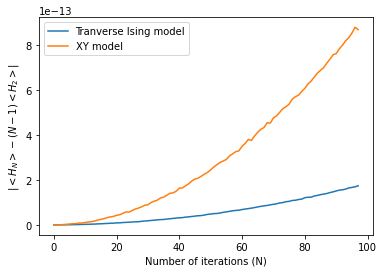

In [50]:
d = 2
D_MPS = 20
W_1 = W_Ising(2,0)
W_2 = W_XY()

U = polar(np.random.rand(d*D_MPS,D_MPS))[0].reshape(D_MPS,d,D_MPS)
R = Transfer_Matrix_MPS(U)
test_1 = np.real(Expectation_Value_Nsite_MPO(2,U,W_1,R))
test_2 = np.real(Expectation_Value_Nsite_MPO(2,U,W_2,R))
x_1 = []
x_2 = []
x_3 = []

y_1 = []
y_2 = []
y_3 = []

for i in range (2,100):
    x_1.append(np.real(Expectation_Value_Nsite_MPO(i,U,W_1,R)))
    x_2.append((i-1)*test_1)
    x_3.append(abs(x_1[i-2]-x_2[i-2]))
    
    y_1.append(np.real(Expectation_Value_Nsite_MPO(i,U,W_2,R)))
    y_2.append((i-1)*test_2)
    y_3.append(abs(y_1[i-2]-y_2[i-2]))

plt.plot(x_3, label = "Tranverse Ising model")
plt.plot(y_3, label = "XY model")
plt.legend()
plt.xlabel('Number of iterations (N)')
plt.ylabel(r'$|<H_N>-(N-1)<H_2>|$')
plt.show()